# The Kinase Library
## Part A: Prediction System
### *Input*: 15-mer (15 amino acids substrate), where the central amino acid is the phospho-acceptor. <br> *Output*: Score and Percentile for the given kinases. <br> *Data provided*: 3 kinase motifs, list of scored phosphoproteome.

**Setting up the environment**

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import percentileofscore

**Reading Kinase Motif files (excluding phosphopriming columns) & Scored Phosphoproteome file**

In [2]:
df_akt = pd.read_table('/Users/danielbarirjensen/Desktop/Python/Datasets/AKT1.txt', header=0, index_col=0)
df_akt = df_akt.drop(["t", "y"], axis=1)
df_akt = df_akt.transpose()

df_cdk = pd.read_table('/Users/danielbarirjensen/Desktop/Python/Datasets/CDK1.txt', header=0, index_col=0)
df_cdk = df_cdk.drop(["t", "y"], axis=1)
df_cdk = df_cdk.transpose()

df_erk = pd.read_table('/Users/danielbarirjensen/Desktop/Python/Datasets/ERK1.txt', header=0, index_col=0)
df_erk = df_erk.drop(["t", "y"], axis=1)
df_erk = df_erk.transpose()

df_scores = pd.read_csv("/Users/danielbarirjensen/Desktop/Python/Datasets/Scored_Phosphoproteome.tsv", index_col=0, delimiter="\t")

**AKT1 Example**

In [3]:
df_akt

,-5,-4,-3,-2,-1,1,2,3,4
P,0.066115,0.095578,0.025668,0.015680,0.102800,0.026358,0.071930,0.115744,0.082208
G,0.075057,0.066560,0.011307,0.040903,0.090285,0.056990,0.127709,0.112188,0.077254
A,0.056223,0.055132,0.014159,0.056419,0.033349,0.020642,0.067503,0.034493,0.035566
C,0.058824,0.052787,0.014567,0.075335,0.028140,0.062831,0.094697,0.060118,0.058455
S,0.054753,0.052247,0.034353,0.194650,0.058824,0.100719,0.299389,0.096362,0.057940
T,0.054377,0.054227,0.030814,0.189400,0.050888,0.076427,0.212070,0.058824,0.085620
V,0.021737,0.024771,0.000472,0.005025,0.009462,0.054035,0.051588,0.030352,0.016429
I,0.030158,0.020086,0.000127,0.001701,0.003816,0.061065,0.027321,0.026797,0.017924
L,0.043189,0.029008,0.000395,0.018827,0.039344,0.071600,0.027663,0.032548,0.031903
M,0.040180,0.066488,0.001295,0.015746,0.065358,0.115219,0.029121,0.042528,0.049723


**Defining function to calculate score and percentile for given kinase and substrate**

In [4]:
def calculate_score_percentile(substrate, kinase):
   
    # Check for input validity
    if len(substrate) != 15:
        return "Error: substrate must have 15 amino acids"
    if substrate[7] not in ['s', 't']:
        return "Error: invalid phospho-acceptor"
    if kinase not in ['AKT1', 'CDK1', 'ERK1']:
        return "Error: invalid kinase"
    
    # Get only the relevant digits of the sequence motif excluding the middle phosphorylation site
    relevant_substrate = substrate[2:7] + substrate[8:12]
    
    # Get probability matrix for given kinase
    if kinase == 'AKT1':
        df = df_akt
    elif kinase == 'CDK1':
        df = df_cdk
    elif kinase == 'ERK1':
        df = df_erk
    
    # Convert non-central amino acids to match kinase matrix format
    if (substrate[7]=='s') or (substrate[7]=='t'):
        relevant_substrate = relevant_substrate.replace('p', 'P')
        relevant_substrate = relevant_substrate.replace('g', 'G')
        relevant_substrate = relevant_substrate.replace('a', 'A')
        relevant_substrate = relevant_substrate.replace('c', 'C')
        relevant_substrate = relevant_substrate.replace('s', 'S')
        relevant_substrate = relevant_substrate.replace('t', 'T')
        relevant_substrate = relevant_substrate.replace('v', 'V')
        relevant_substrate = relevant_substrate.replace('i', 'I')
        relevant_substrate = relevant_substrate.replace('l', 'L')
        relevant_substrate = relevant_substrate.replace('m', 'M')
        relevant_substrate = relevant_substrate.replace('f', 'F')
        relevant_substrate = relevant_substrate.replace('y', 'Y')
        relevant_substrate = relevant_substrate.replace('w', 'W')
        relevant_substrate = relevant_substrate.replace('h', 'H')
        relevant_substrate = relevant_substrate.replace('k', 'K')
        relevant_substrate = relevant_substrate.replace('r', 'R')
        relevant_substrate = relevant_substrate.replace('q', 'Q')
        relevant_substrate = relevant_substrate.replace('n', 'N')
        relevant_substrate = relevant_substrate.replace('d', 'D')
        relevant_substrate = relevant_substrate.replace('e', 'E')
        
        # Calculate score
        init_score = reduce(lambda x, y: x * y, map(lambda x: df[x[1]][x[0]] if x[0] != '_' else 1/17, zip(relevant_substrate,[-5,-4,-3,-2,-1,1,2,3,4])))
        score = init_score/(1/17**9)
        
        # Calculate percentile
        kinase_col = df_scores[kinase]
        percentile = percentileofscore(kinase_col, score, kind='rank')
        
        # Combine results into string
        result = f"Substrate: {substrate}, Kinase: {kinase}, Score: {round(score,6)}, Percentile: {round(percentile,2)}%"
        
    return round(score,4), round(percentile,2)

**Running and validating the function**

In [5]:
substrate = 'EAPQEPQs_______'
kinase = 'CDK1'

calculate_score_percentile(substrate, kinase)

(5.1029, 73.75)

**What is the conceptual difference between score and percentile?**

The conceptual difference between score and percentile is that the score reflects how well a substrate responds to
a given kinase, whereas the percentile indicates how that substrate performs against all other substrates for that
given kinase (takes into account the selectivity of the kinase).

## Part B: Performance Analysis
### *Input*: Kinase <br> *Output*: ROC curve and AUC <br> *Data Provided*: List of kinase-substrate pairs, human proteome

In [10]:
# Read Kinase Substrate Known Pairs file
df_knownpairs = pd.read_table('/Users/danielbarirjensen/Desktop/Python/Datasets/Kinase_Substrate_known_pairs.txt', sep='\t', header=0)

# Filter out non-human substrates 
df_knownpairs = df_knownpairs[df_knownpairs['SUB_ORGANISM'] == 'human']

# Create separate dataframes for each kinase
df_atk_knownpairs = df_knownpairs[df_knownpairs['KINASE'] == 'Akt1']

df_cdk_knownpairs = df_knownpairs[df_knownpairs['KINASE'] == 'CDK1']

df_erk_knownpairs = df_knownpairs[df_knownpairs['KINASE'] == 'ERK1']

In [11]:
# Create empty dataframes with column names
df_akttest = pd.DataFrame(columns=['Substrate', 'Percentile'])

# Add the list of all values in the index column of df_scores to the 'Substrate' columns
df_akttest['Substrate'] = df_scores.index.tolist()

# Use apply() method to calculate percentile scores and fill the 'Percentile' column
df_akttest['Percentile'] = df_akttest['Substrate'].apply(lambda x: calculate_score_percentile(x,'AKT1')[1])

# Set the 'Phosphorylation' column based on the three conditions
df_akttest.loc[df_akttest['Substrate'].str.upper().isin(df_atk_knownpairs['SITE_+/-7_AA'].str.upper()), 'Phosphorylation'] = 1
df_akttest.loc[~df_akttest['Substrate'].str.upper().isin(df_atk_knownpairs['SITE_+/-7_AA'].str.upper()) & (df_akttest['Percentile'] >= 90), 'Phosphorylation'] = 1
df_akttest.loc[~df_akttest['Substrate'].str.upper().isin(df_atk_knownpairs['SITE_+/-7_AA'].str.upper()) & (df_akttest['Percentile'] < 90), 'Phosphorylation'] = 0

In [12]:
df_akttest.head()

,Substrate,Percentile,Phosphorylation
0,__MtMDksELVQkAk,2.59,0.0
1,NEERNLLsVAykNVV,40.95,0.0
2,VVGARRssWRVISsI,87.76,0.0
3,FyYEILNsPEKACSL,6.56,0.0
4,VEERNLLsVAykNVI,40.95,0.0


In [13]:
# Looking up count of negative substrates vs. positive substrates
print(df_akttest['Phosphorylation'].value_counts())

0.0    34605
1.0     3960
Name: Phosphorylation, dtype: int64


In [14]:
# Splitting into dependent and independent variables
X = df_akttest.iloc[:,1].values
y = df_akttest.iloc[:,2].values

## *Train-Test Split*

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train = np.array(X_train).reshape(-1, 1)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, 1)
y_test = np.array(y_test)

## *Logistic Classifier*

In [16]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

y_pred_logistic = model_logistic.decision_function(X_test)

## *Plot ROC and compare AUC*

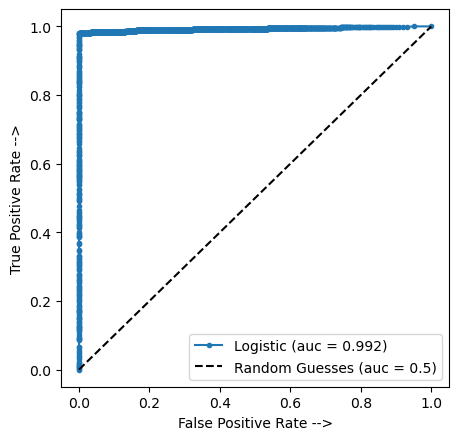

In [17]:
from sklearn.metrics import roc_curve, auc

logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_logistic)
auc_logistic = auc(logistic_fpr, logistic_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guesses (auc = 0.5)')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()